In [1]:
import sys
sys.path.append('/Users/julnow/gsi/ml-pid-cbm')
from ml_pid_cbm.tools import json_tools, plotting_tools
from ml_pid_cbm.tools.load_data import LoadData
from ml_pid_cbm.validate_model import ValidateModel
import os
from collections import defaultdict
from ml_pid_cbm.tools.particles_id import ParticlesId as Pid
from sklearn.metrics import confusion_matrix
import gc


/opt/homebrew/Caskroom/miniforge/base/envs/cbm22/lib/python3.8/site-packages/fasttreeshap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/opt/homebrew/Caskroom/miniforge/base/envs/cbm22/lib/python3.8/site-packages/fasttreeshap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-whe

In [4]:
json_file_name = "config.json"
file_name = "/Users/julnow/gsi/mgr/trees/PlainTree500k_URQMD_tof_gauss_12agev.root"
n_workers = 10
# loading test data
def perform_everything(lower_p, upper_p):
    lower_p, upper_p, is_anti = lower_p, upper_p, False
    loader = LoadData(file_name, json_file_name, lower_p, upper_p, is_anti)
    # sigma selection
    # loading model handler and applying on dataset
    print(
        f"\nLoading data from {file_name}"
    )

    test_particles = loader.load_tree(max_workers=n_workers)
    df = test_particles.get_data_frame()

    #remapping names for MC pdg and gauss PDG
    df["Complex_gauss_pid"] = (
        df["Complex_gauss_pid"]
        .map(
            defaultdict(
                lambda: 3.0,
                {
                    Pid.PROTON.value: 0.0,
                    Pid.POS_KAON.value: 1.0,
                    Pid.POS_PION.value: 2.0,
                    Pid.POSITRON.value: 2.0,
                    Pid.POS_MUON.value: 2.0,
                },
            ),
            na_action="ignore",
        )
        .astype(float)
    )
    df["Complex_pid"] = (
        df["Complex_pid"]
        .map(
            defaultdict(
                lambda: 3.0,
                {
                    Pid.PROTON.value: 0.0,
                    Pid.POS_KAON.value: 1.0,
                    Pid.POS_PION.value: 2.0,
                    Pid.POSITRON.value: 2.0,
                    Pid.POS_MUON.value: 2.0,
                },
            ),
            na_action="ignore",
        )
        .astype(float)
    )
    cnf_matrix = confusion_matrix(
    df["Complex_pid"], df["Complex_gauss_pid"]
    )
    plotting_tools.plot_confusion_matrix(cnf_matrix, save_fig=False)
    plotting_tools.plot_confusion_matrix(cnf_matrix, normalize=True, save_fig=False)
    classes_names = ["protons", "kaons", "pions"]
    for pid, particle_name in enumerate(classes_names):        
        plotting_tools.tof_plot(
            df[df["Complex_pid"] == pid],
            json_file_name,
            f"{particle_name} (all simulated)",
        )

        plotting_tools.tof_plot(
            df[df["Complex_gauss_pid"] == pid],
            json_file_name,
            f"{particle_name} (gauss-selected)",
        )
    del df
    gc.collect()


Loading data from /Users/julnow/gsi/mgr/trees/PlainTree500k_URQMD_tof_gauss_12agev.root

Loading tree from /Users/julnow/gsi/mgr/trees/PlainTree500k_URQMD_tof_gauss_12agev.root...
Confusion matrix, without normalization
[[ 628693    7431   48131   72959]
 [      8  129628    6293    6475]
 [     11     468 2930532   67527]
 [     10     153   19539   12747]]


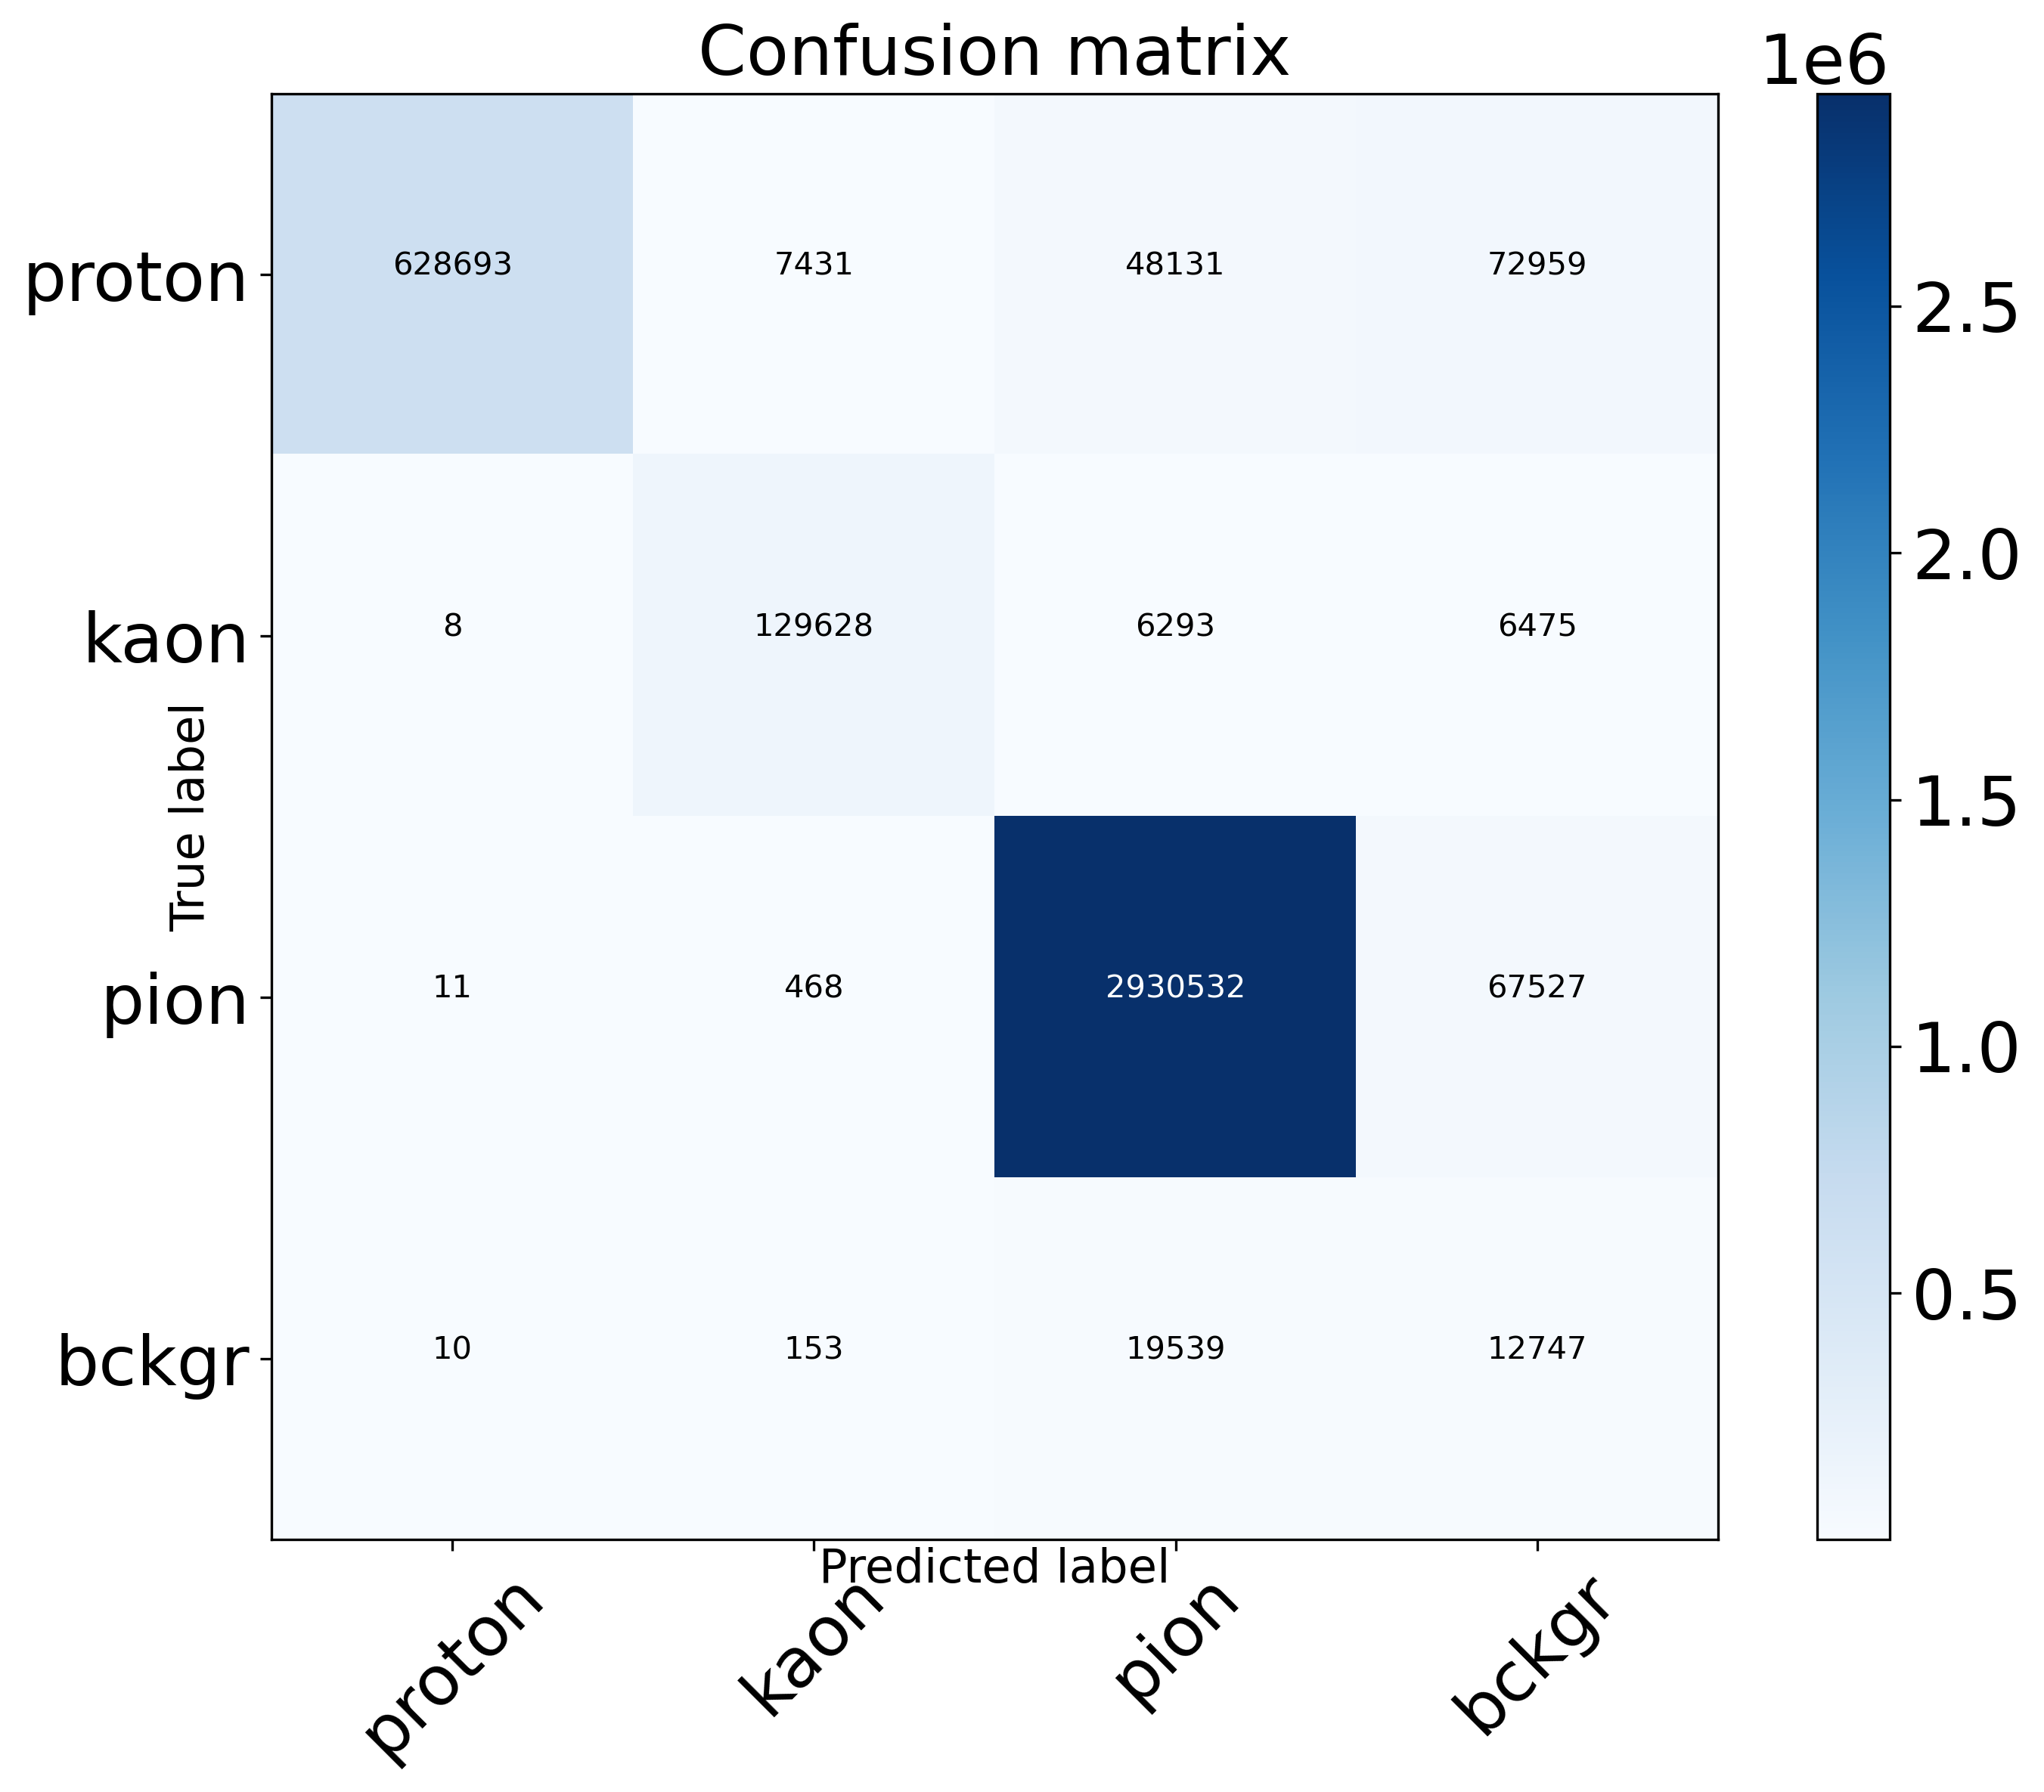

Normalized confusion matrix
[[8.30e-01 9.81e-03 6.36e-02 9.64e-02]
 [5.62e-05 9.10e-01 4.42e-02 4.55e-02]
 [3.67e-06 1.56e-04 9.77e-01 2.25e-02]
 [3.08e-04 4.72e-03 6.02e-01 3.93e-01]]


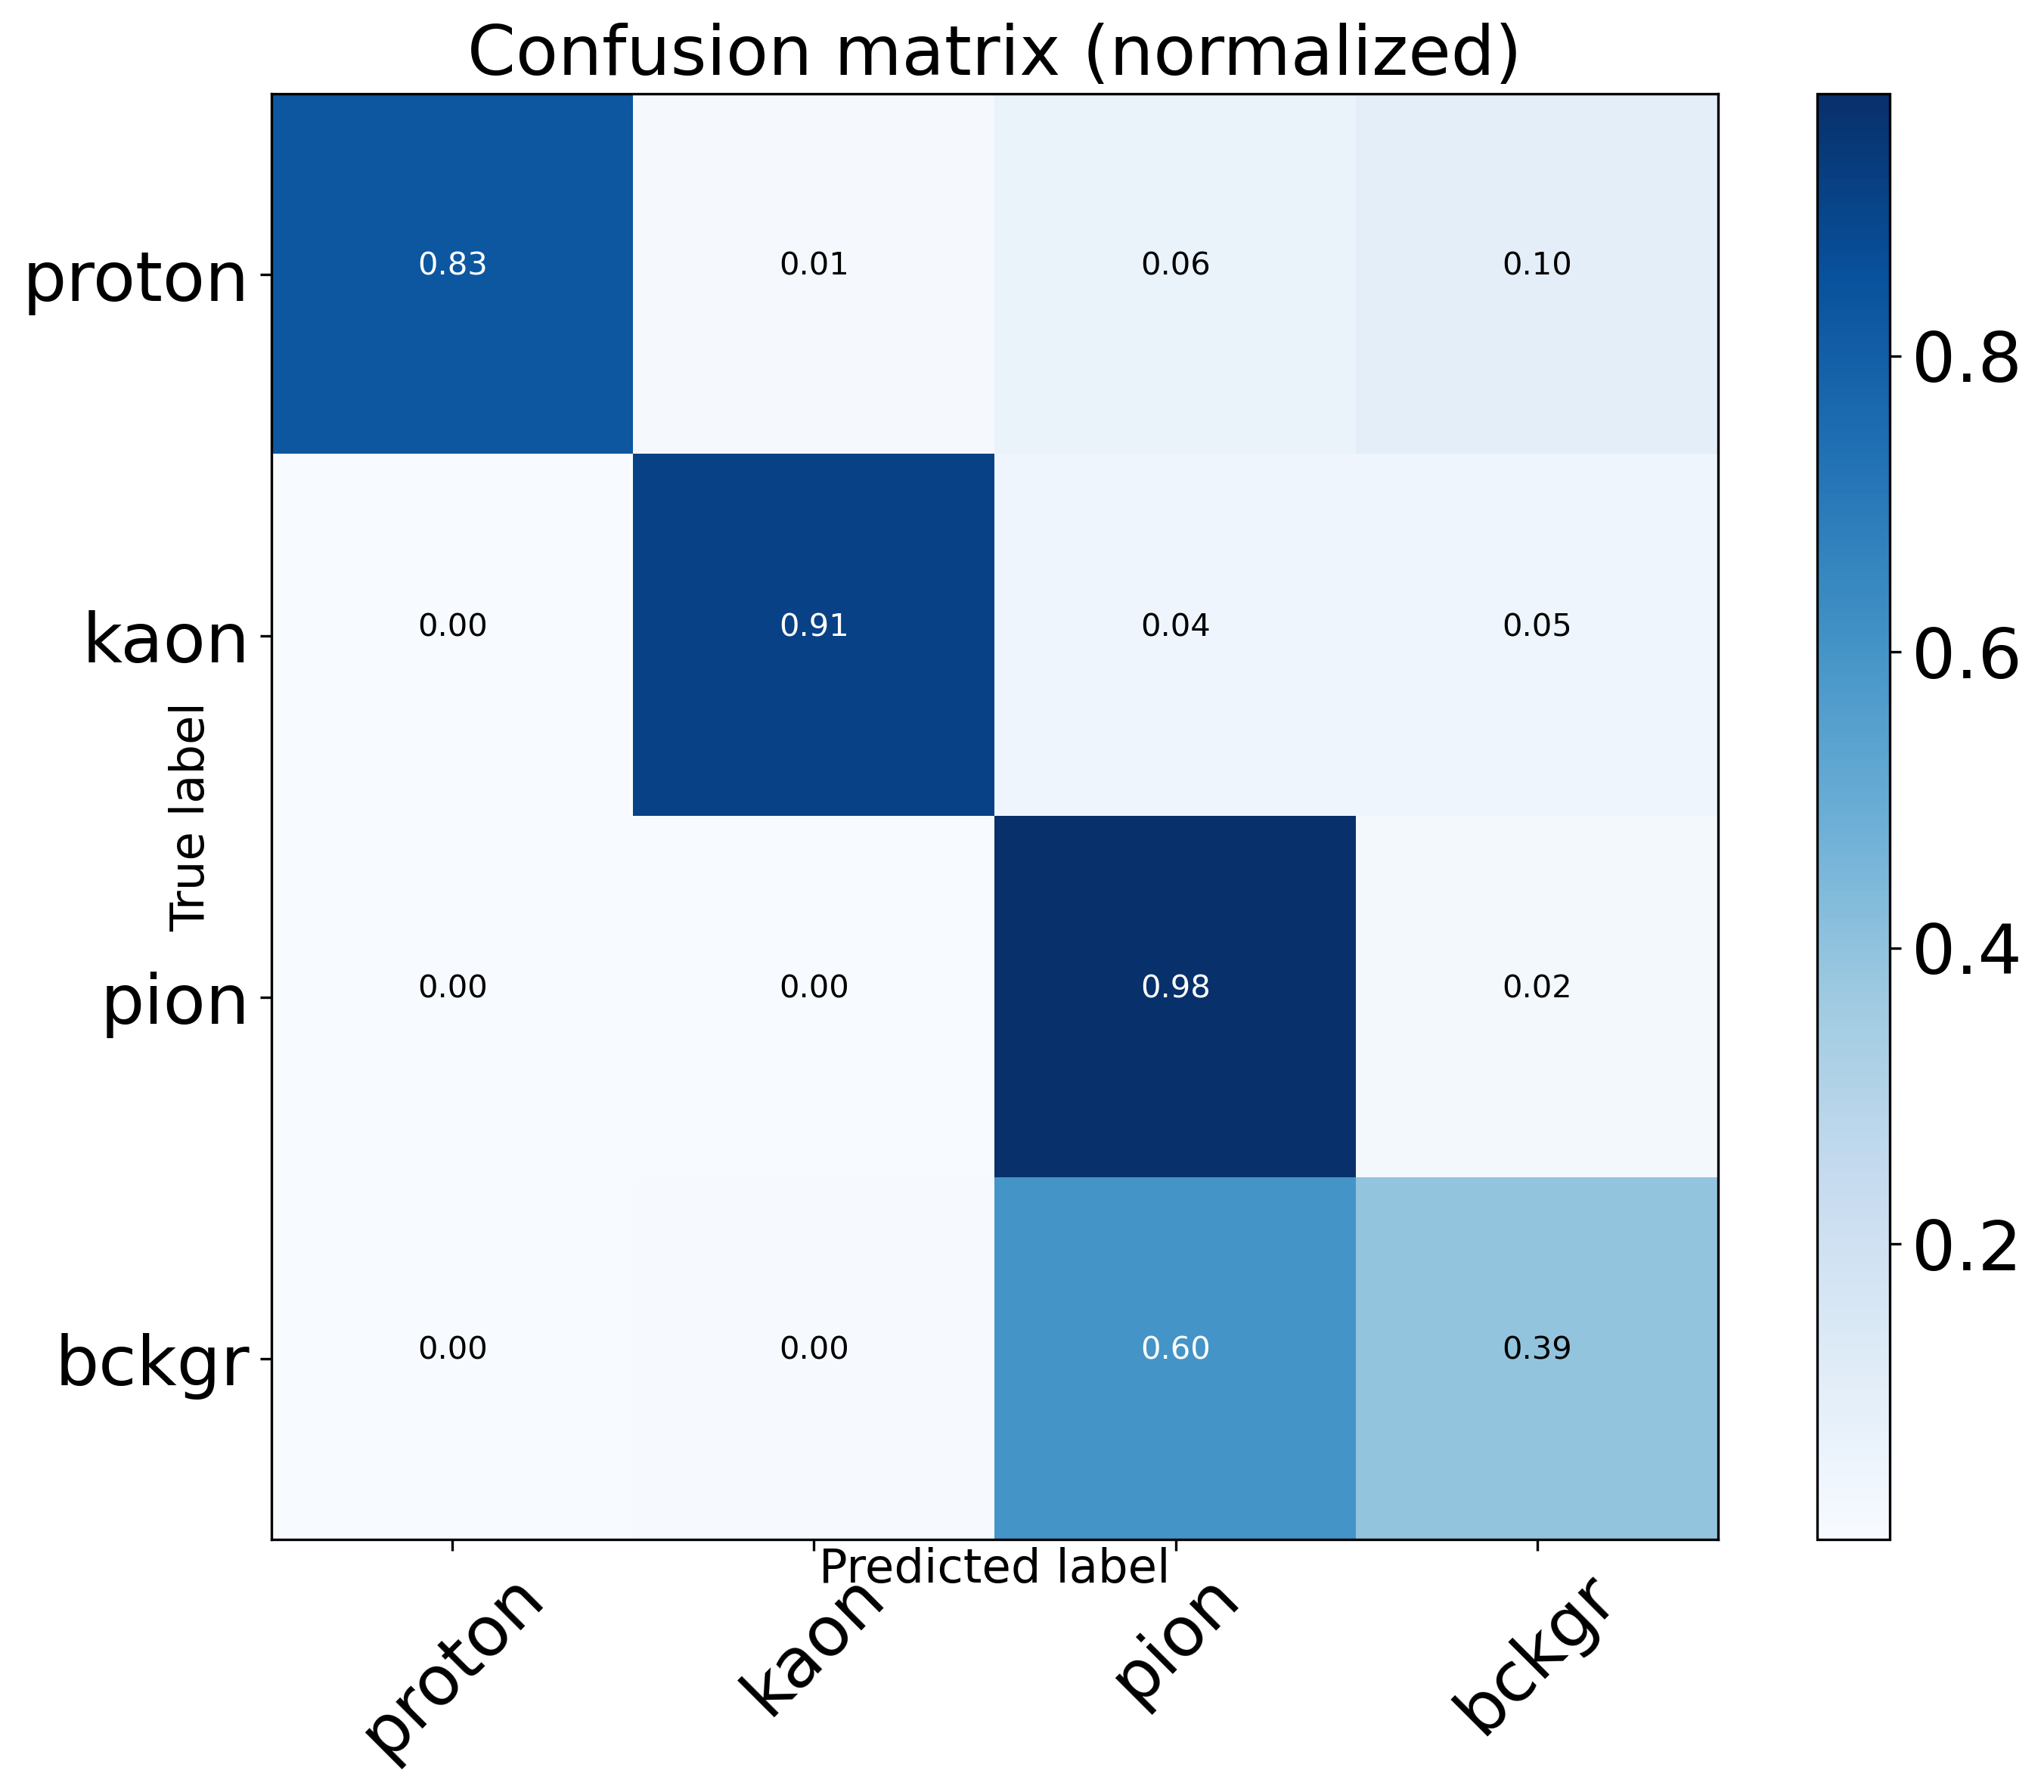

In [6]:
perform_everything(0, 1.6)